# Analyzing machine learning model testing results #

## A NOTE BEFORE STARTING ##

Since the ``emicroml`` git repository tracks this notebook under its original
basename ``analyzing_ml_model_testing_results.ipynb``, we recommend that you
copy the original notebook and rename it to any other basename that is not one
of the original basenames that appear in the ``<root>/examples`` directory
before executing any of the notebook cells below, where ``<root>`` is the root
of the ``emicroml`` repository. For example, you could rename it
``analyzing_ml_model_testing_results_sandbox.ipynb``. This way you can explore
the notebook by executing and modifying cells without changing the original
notebook, which is being tracked by git.

## Table of contents ##

- [Import necessary modules](#Import-necessary-modules)
- [Introduction](#Introduction)
- [Loading and analyzing the ML testing datasets](#Loading-and-analyzing-the-ML-testing-datasets)
- [Loading and analyzing the ML model testing summary output data](#Loading-and-analyzing-the-ML-model-testing-summary-output-data)

## Import necessary modules ##

In [1]:
# For adding new directories in which to search for local Python modules. Only
# used at the end of the current notebook cell.
import sys



# For loading CBED patterns.
import prismatique.load

# For cropping HyperSpy signals.
import empix

# For loading objects from HDF5 files.
import h5pywrappers

# For creating and plotting figures.
import matplotlib.pyplot as plt



# For loading ML datasets for testing distortion estimation in CBED.
import emicroml.modelling.cbed.distortion.estimation

# For visualizing some data. Users need not focus on the implementation details
# of this module in order to follow the logic of each cell in the remainder of
# this notebook. Morevoer, users need not import this module for their own
# applications of ``emicroml``.
sys.path.insert(0, "..")
import helpers.for_analyzing_ml_model_testing_results as helpers

## Introduction ##

In this notebook, we analyze the output that results from performing the
"actions" described in the following pages:

1. [Generating simulated CBED patterns of a sample of $\ce{MoS2}$ on amorphous C](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/simulations/MoS2_on_amorphous_C/generate_cbed_pattern_sets.html)
2. [Generating machine learning datasets for the machine learning model test set #1](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/generate_ml_datasets_for_ml_model_test_set_1.html)
3. [Combining machine learning datasets for the machine learning model test set #1](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/combine_ml_datasets_for_ml_model_test_set_1.html)
4. [Running the machine learning model test set #1](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/run_ml_model_test_set_1.html)
5. [Running the RGM test set #1](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/run_rgm_test_set_1.html)

In short, in this notebook we analyze the performance results of the "first" set
of machine learning (ML) model tests for the ML task of estimating distortion in
convergent beam electron diffraction (CBED). These performance results are
benchmarked against those obtained by the radial gradient maximization (RGM)
approach to estimating distortion.

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    torch
    pyprismatic>=2.0
    jupyter
    ipympl
    prismatique
    emicroml

Before installing `emicroml`, it is recommended that users install `torch`
(i.e. `PyTorch`) in the same environment that they intend to install `emicroml`
according to the instructions given
[here](https://pytorch.org/get-started/locally/) for their preferred `PyTorch`
installation option. The Python library `pyprismatic>=2.0` must also be
installed prior to `emicroml`. The easiest way to install this additional
dependency is within a `conda` virtual environment, using the following command:

    conda install -y pyprismatic=*=gpu* -c conda-forge

if CUDA version >= 11 is available on our machine, otherwise users should run
instead the following command:

    conda install -y pyprismatic=*=cpu* -c conda-forge

After installing `torch` and `pyprismatic`, users can install the remaining
libraries by running the following command in a terminal:

    pip install emicroml prismatique jupyter ipympl

The `emicroml` repository contains a script located at
`<root>/default_env_setup_for_slurm_jobs.sh` that will attempt to create a
virtual environment, then activate it, and then install all the libraries
required to run all of the examples in said repository, when executed with
appropriately chosen command line arguments. As an alternative to the manual
installation procedure above, users can try the automated approach that involves
executing the aforementioned script. See [this
page](https://mrfitzpa.github.io/emicroml/examples/prerequisites_for_execution_without_slurm.html)
for instructions on how to do so.

A subset of the output that results from performing the "actions" mentioned at
the beginning of this section is required to execute the cells in this notebook
as intended. One can obtain this subset of output by executing said actions,
however this requires significant computational resources, including significant
walltime. Alternatively, one can copy this subset of output from a Federated
Research Data Repository (FRDR) dataset by following the instructions given on
[this
page](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/copying_subset_of_output_from_frdr_dataset.html).
For this particular notebook, the only directories that one would need to copy
from the FRDR dataset are:
    
    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/ml_datasets/ml_datasets_for_ml_model_test_set_1
    
    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/ml_models/ml_model_1/ml_model_test_set_1_results

    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/rgm_test_set_1_results

where `<frdr_dataset_root>` is the root of the FRDR dataset, and the only files
that one would need to copy from the FRDR dataset are:

    <frdr_dataset_root>/emicroml/examples/modelling/cbed/simulations/MoS2_on_amorphous_C/data/cbed_pattern_generator_output/patterns_with_small_sized_disks/stem_sim_intensity_output.h5

    <frdr_dataset_root>/emicroml/examples/modelling/cbed/simulations/MoS2_on_amorphous_C/data/cbed_pattern_generator_output/patterns_with_medium_sized_disks/stem_sim_intensity_output.h5

    <frdr_dataset_root>/emicroml/examples/modelling/cbed/simulations/MoS2_on_amorphous_C/data/cbed_pattern_generator_output/patterns_with_large_sized_disks/stem_sim_intensity_output.h5

You can find the documentation for the `emicroml` library
[here](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.html). It is
recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of `emicroml` that they are currently using.**

The last module that we imported above (i.e. the module with the alias
`helpers`) contains helper functions that are used throughout the remainder of
the notebook, specifically to visualize some data. It is not essential that
users know the implementation details of these helper functions in order to
follow the logic of each cell in the remainder of this notebook. Moreover, users
need not import this module for their own applications of `emicroml`. That being
said, if any users are interested in the implementation details, they can find
them in the file
`<root>/examples/modelling/cbed/distortion/estimation/helpers/for_analyzing_ml_model_testing_results.py`.

## Loading and analyzing the ML testing datasets ##

Upon successful completion of the action described in the page [Combining
machine learning datasets for the machine learning model test set
#1](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/combine_ml_datasets_for_ml_model_test_set_1.html),
for every string `<disk_size>` in the sequence `(small, medium, large)`, a ML
testing dataset is stored in the HDF5 file at the file path
`../data/ml_datasets/ml_datasets_for_ml_model_test_set_1/ml_datasets_with_cbed_patterns_of_MoS2_on_amorphous_C/ml_dataset_with_<disk_size>_sized_disks.h5`,
where the ML dataset contains 2880 ML data instances, with each ML dataset
instance storing a $512 \times 512$ "fake" CBED pattern obtained by randomly
distorting the same undistorted CBED pattern with `<disk_size>`-sized CBED
disks. For every string `<disk_size>` in the sequence `(small, medium, large)`,
the undistorted CBED pattern with `<disk_size>`-sized CBED disks is the final
CBED pattern of a CBED experiment simulated via the multislice technique, where
the sample is a 5-layer thin film with a thick layer of amorphous carbon (C). By
small-, medium-, and large-sized CBED disks, we mean CBED disks with radii equal
roughly to $1/35$, $(1/35+1/10)/2$, and $1/10$ in units of the image width,
respectively.

Let's start by visualizing the three undistorted fake CBED patterns. Note that
in the cell below, we crop each undistorted fake CBED pattern to $512 \times
512$, i.e. the same dimensions, in units of pixels, of each distorted fake CBED
pattern.:

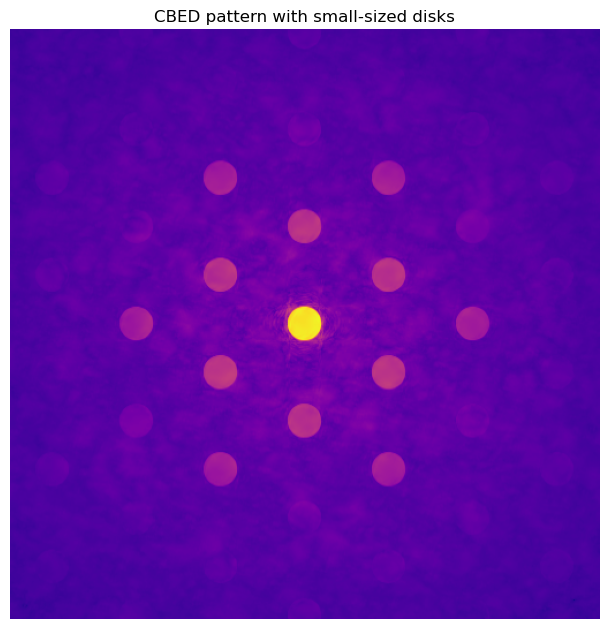

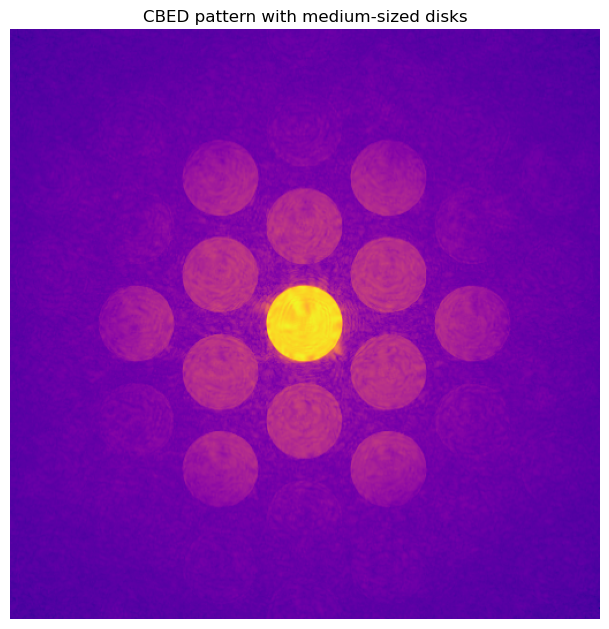

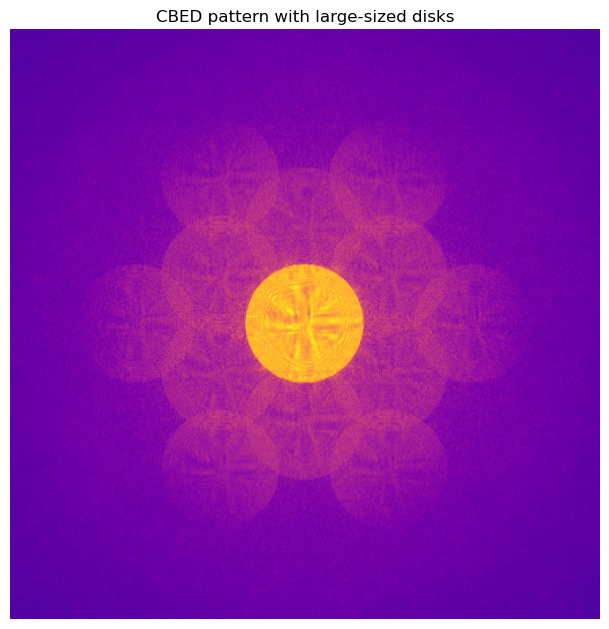

In [2]:
path_to_data_dir = "../../../simulations/MoS2_on_amorphous_C/data"
disk_sizes = ("small", "medium", "large")



for disk_size in disk_sizes:
    filename = (path_to_data_dir
                + "/cbed_pattern_generator_output/patterns_with_{}_sized_disks"
                + "/stem_sim_intensity_output.h5").format(disk_size)


    
    kwargs = \
        {"filename": filename, "multi_dim_slice": (0, 0)}
    cbed_intensity_pattern_signal, _ = \
        prismatique.load.cbed_intensity_patterns(**kwargs)


    
    cropping_window_dims = \
        (cbed_intensity_pattern_signal.axes_manager["$k_x$"].size//2,
         cbed_intensity_pattern_signal.axes_manager["$k_y$"].size//2)

    kwargs = {"window_dims": cropping_window_dims}
    optional_cropping_params = empix.OptionalCroppingParams(**kwargs)
    
    kwargs = {"input_signal": cbed_intensity_pattern_signal,
              "optional_params": optional_cropping_params}
    cropped_cbed_intensity_pattern_signal = empix.crop(**kwargs)

    

    %matplotlib inline
    
    kwargs = {"axes_off": True, 
              "scalebar": False, 
              "colorbar": False, 
              "gamma": 0.2,
              "cmap": "plasma", 
              "title": "CBED pattern with {}-sized disks".format(disk_size)}
    cropped_cbed_intensity_pattern_signal.plot(**kwargs)

Let's now visualize a single distorted CBED pattern from the ML testing dataset
of CBED patterns with medium-sized disks:

In [3]:
disk_size = "medium"

path_to_data_dir = "../data"

path_to_ml_dataset = (path_to_data_dir
                      + "/ml_datasets"
                      + "/ml_datasets_for_ml_model_test_set_1"
                      + "/ml_datasets_with_cbed_patterns_of_MoS2_on_amorphous_C"
                      + "/ml_dataset_with_{}_sized_disks.h5").format(disk_size)



module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"path_to_ml_dataset": path_to_ml_dataset, 
          "entire_ml_dataset_is_to_be_cached": False, 
          "ml_data_values_are_to_be_checked": False}
ml_dataset = module_alias.MLDataset(**kwargs)



cbed_pattern_idx = 1
sampling_grid_dims_in_pixels = cropping_window_dims

kwargs = \
    {"single_dim_slice": slice(cbed_pattern_idx, cbed_pattern_idx+1), 
     "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
ml_data_instances_as_signals = \
    ml_dataset.get_ml_data_instances_as_signals(**kwargs)

ml_data_instances_as_signal = ml_data_instances_as_signals[0]



%matplotlib ipympl

kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
ml_data_instances_as_signal.plot(**kwargs)

Note how we've added random illumination support shapes to some of the distorted
CBED patterns in each ML testing data.

## Loading and analyzing the ML model testing summary output data ##

Upon successful completion of the action described in the page [Training machine
learning
models](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/train_ml_model_set.html),
10 ML models are trained, and a dictionary representation of each ML model is
saved to a file. Here we assume that said ML models have been trained
already. Furthermore, upon successful completion of the action described in the
page [Running the machine learning model test set
#1](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/run_ml_model_test_set_1.html),
for every string `<disk_size>` in the sequence `(small, medium, large)`, for
every nonnegative integer `<k>` less than 10, the `<k>` th trained ML model will
have been tested against the ML testing dataset stored in the HDF5 file at the
file path
`../data/ml_datasets/ml_datasets_for_ml_model_test_set_1/ml_datasets_with_cbed_patterns_of_MoS2_on_amorphous_C/ml_dataset_with_<disk_size>_sized_disks.h5`,
with the ML model testing having been performed using the class
emicroml.modelling.cbed.distortion.estimation.MLModelTester, and the ML model
testing summary output data file having been saved to the HDF5 file at the file
path
`../data/ml_models/ml_model_<k>/ml_model_test_set_1_results/results_for_cbed_patterns_of_MoS2_on_amorphous_C_with_<disk_size>_sized_disks/ml_model_testing_summary_output_data.h5`.
ML model testing summary output data files are described in detail in the
documentation for the method
[emicroml.modelling.cbed.distortion.estimation.MLModelTester.test_ml_model](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.MLModelTester.html#emicroml.modelling.cbed.distortion.estimation.MLModelTester.test_ml_model).

Upon successful completion of the action described in the page [Running the RGM
test set
#1](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/run_rgm_test_set_1.html),
for every string `<disk_size>` in the sequence `(small, medium, large)`, the RGM
approach to distortion estimation will have been tested against the ML testing
dataset stored in the HDF5 file at the file path
`../data/ml_datasets/ml_datasets_for_ml_model_test_set_1/ml_datasets_with_cbed_patterns_of_MoS2_on_amorphous_C/ml_dataset_with_<disk_size>_sized_disks.h5`,
with the testing summary output data file having been saved to the HDF5 file at
the file path
`../data/ml_models/ml_model_0/ml_model_test_set_1_results/results_for_cbed_patterns_of_MoS2_on_amorphous_C_with_<disk_size>_sized_disks/rgm_testing_summary_output_data.h5`.

For all testing summary output data files, the end-point error (EPE) of the
predicted "adjusted" standard distortion field is tracked as a performance
metric. For each ML testing dataset, let's compare the ML approach to the RGM
approach, by plotting the cumulative distribution function (CDF) of the
aforementioned performance metric:

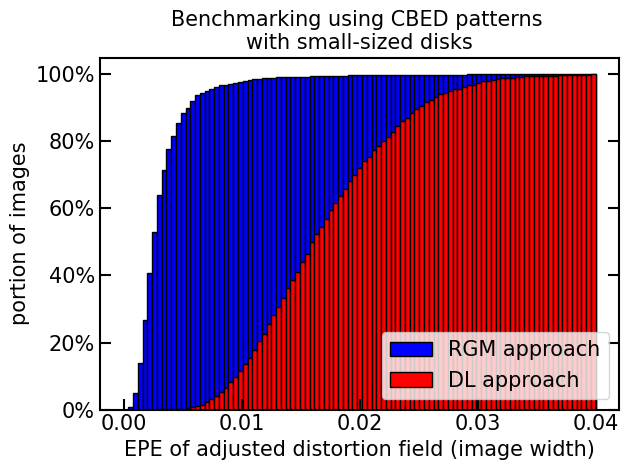

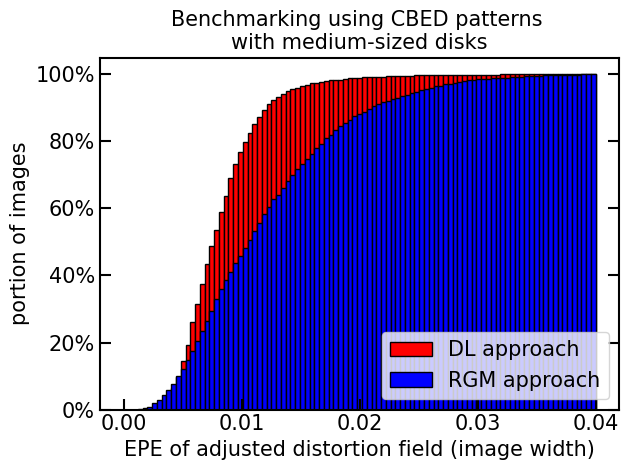

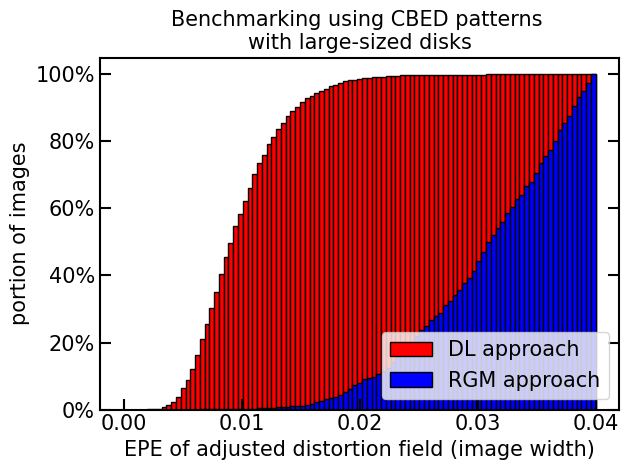

In [4]:
for disk_size_idx, disk_size in enumerate(disk_sizes):
    path_to_ml_model_testing_summary_output_data = \
        (path_to_data_dir
         + "/ml_models"
         + "/ml_model_1/ml_model_test_set_1_results"
         + "/results_for_cbed_patterns_of_MoS2_on_amorphous_C"
         + "_with_{}_sized_disks"
         + "/ml_model_testing_summary_output_data.h5").format(disk_size)
    path_to_rgm_testing_summary_output_data = \
        (path_to_data_dir
         + "/rgm_test_set_1_results"
         + "/results_for_cbed_patterns_of_MoS2_on_amorphous_C"
         + "_with_{}_sized_disks"
         + "/rgm_testing_summary_output_data.h5").format(disk_size)

    

    filename_to_legend_label_map = \
        {path_to_ml_model_testing_summary_output_data: "DL approach",
         path_to_rgm_testing_summary_output_data: "RGM approach"}

    filenames = (path_to_rgm_testing_summary_output_data, 
                 path_to_ml_model_testing_summary_output_data)
    if disk_size_idx != 0:
        filenames = filenames[::-1]


    
    x_set = tuple()
    legend_label_set = tuple()

    for filename in filenames:
        hdf5_dataset_path = ("/ml_data_instance_metrics/testing"
                             "/epes_of_adjusted_distortion_fields")

        kwargs = {"filename": filename, "path_in_file": hdf5_dataset_path}
        hdf5_dataset_id = h5pywrappers.obj.ID(**kwargs)

        kwargs = {"dataset_id": hdf5_dataset_id,
                  "multi_dim_slice": (slice(None),)}
        hdf5_datasubset_id = h5pywrappers.datasubset.ID(**kwargs)

        kwargs = {"datasubset_id": hdf5_datasubset_id}
        x = h5pywrappers.datasubset.load(**kwargs)

        x_set += (x,)
        legend_label_set += (filename_to_legend_label_map[filename],)



    title = ("Benchmarking using CBED patterns \n"
             "with {}-sized disks").format(disk_size)



    plt.close("all")  # Close all previous figures to release memory.
    %matplotlib inline
    
    kwargs = {"x_set": x_set, 
              "legend_label_set": legend_label_set, 
              "title": title}
    helpers.plot_multiple_cdf_curves(**kwargs)

As we can see from the figures, the RGM approach outperforms the ML approach for
the case of small-sized CBED disks, whereas the ML approach is comparable
performance-wise to the RGM approach for the case of medium-sized disks, and
outperforms the RGM approach for the case of large-sized CBED disks. The fact
that the ML approach outperforms the RGM approach for the case of large-sized
CBED disks is likely due to the fact that the CBED disks are overlapping.